# Notes on Chapter 2 of Hands-On Machine Learning with Scikit-Learn & TensorFlow by Aurélien Géron

In [1]:
#import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import math
import hashlib


housing = pd.read_csv("handson-ml/datasets/housing/housing.csv");

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


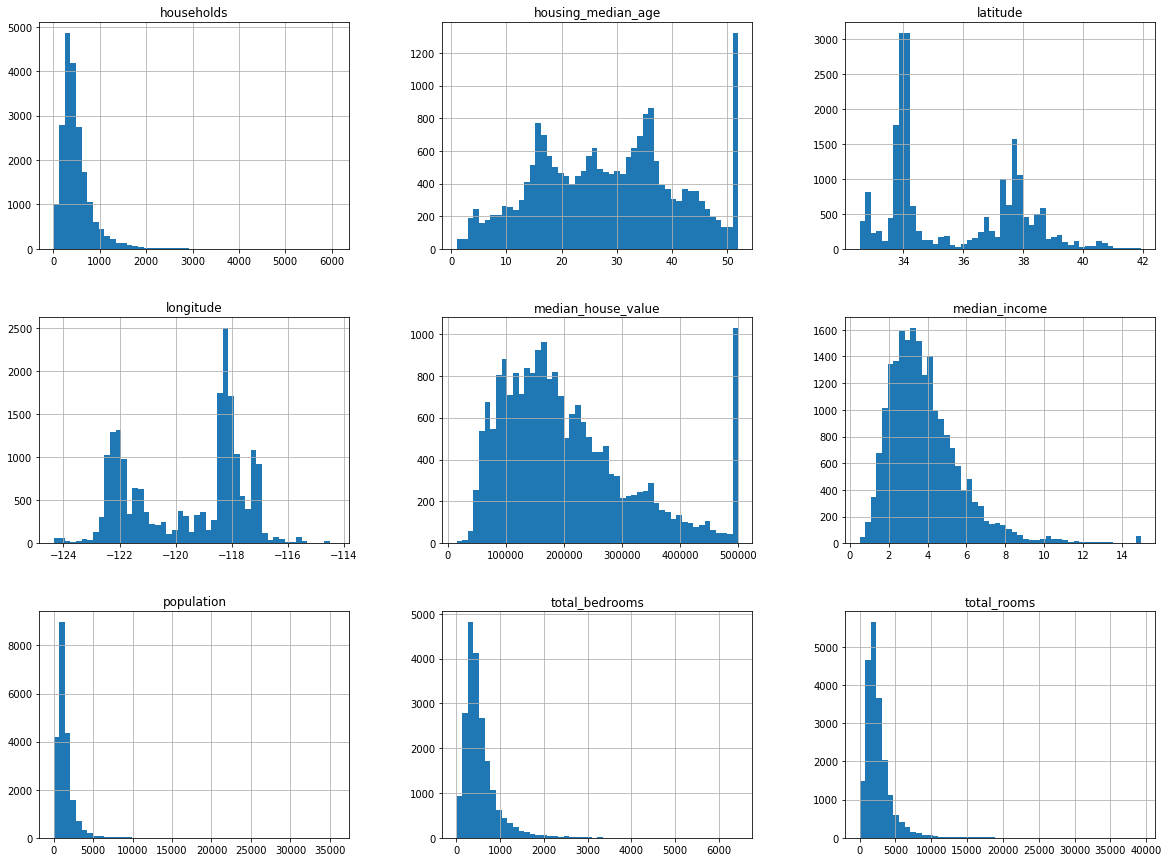

In [6]:
housing.hist(bins=50, figsize=(20,15));

## Splitting test and training data

### Random split

In [7]:
def split_test_train(data, test_ratio=0.2):
    permutation = np.random.permutation(len(data))
    test_set_size = round(len(data) * test_ratio)
    return data.iloc[permutation[:test_set_size]], data.iloc[permutation[test_set_size:]]

In [8]:
dummy_data = pd.Series(list("ABCDEFGHIJKLMNOP"))
split_test_train(dummy_data, 0.2)

(14    O
 2     C
 15    P
 dtype: object, 7     H
 0     A
 1     B
 6     G
 8     I
 3     D
 9     J
 10    K
 4     E
 13    N
 5     F
 11    L
 12    M
 dtype: object)

In [49]:
np.random.seed(42)
test1, train1 = split_test_train(housing, 0.2)
print("test: {0}, train {1}".format(len(test1), len(train1)))

test: 4128, train 16512


sklearn has a built-in function to do this split:

In [54]:
from sklearn.model_selection import train_test_split
train1, test1 = train_test_split(housing, test_size=0.2, random_state=42)
print("test: {0}, train {1}".format(len(test1), len(train1)))

test: 4128, train 16512


### Split based on hash of the index (ideally something like MRN)

In [57]:
def uniform_deviate_from_value(val):
    m = hashlib.sha512()
    m.update(bytes(val))
    s = m.digest()
    bits_per_byte = 8
    bytes_used = 8
    return sum([s[i] << (bits_per_byte*i) for i in range(bytes_used)])/(math.pow(2, bytes_used*bits_per_byte) - 1)

In [58]:
def hash_split_test_train(data, test_ratio=0.2):
    is_train = np.array([uniform_deviate_from_value(i) > test_ratio for i in data.index])
    is_test = np.logical_not(is_train)
    return data.iloc[is_test], data.iloc[is_train]

In [59]:
hash_split_test_train(dummy_data, 0.2)

(3     D
 6     G
 11    L
 dtype: object, 0     A
 1     B
 2     C
 4     E
 5     F
 7     H
 8     I
 9     J
 10    K
 12    M
 13    N
 14    O
 15    P
 dtype: object)

In [74]:
test, train = hash_split_test_train(housing, 0.2)
print("test: {0}, train {1}".format(len(test), len(train)))

test: 4180, train 16460


### Stratified sampling

In [60]:
housing["income_cat"] = np.ceil(housing.median_income/1.5)
housing.income_cat.where(housing.income_cat < 5, 5.0, inplace=True)

In [65]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_index, test_index = next(split.split(housing, housing.income_cat))
strat_train_set = housing.loc[train_index]
strat_test_set = housing.loc[test_index]
    

In [75]:
pd.DataFrame([x.income_cat.value_counts() / len(x) for x in [housing, strat_train_set, strat_test_set]])

,3.0,2.0,4.0,5.0,1.0
income_cat,0.350581,0.318847,0.176308,0.114438,0.039826
income_cat,0.350594,0.318859,0.176296,0.114402,0.039850
income_cat,0.350533,0.318798,0.176357,0.114583,0.039729


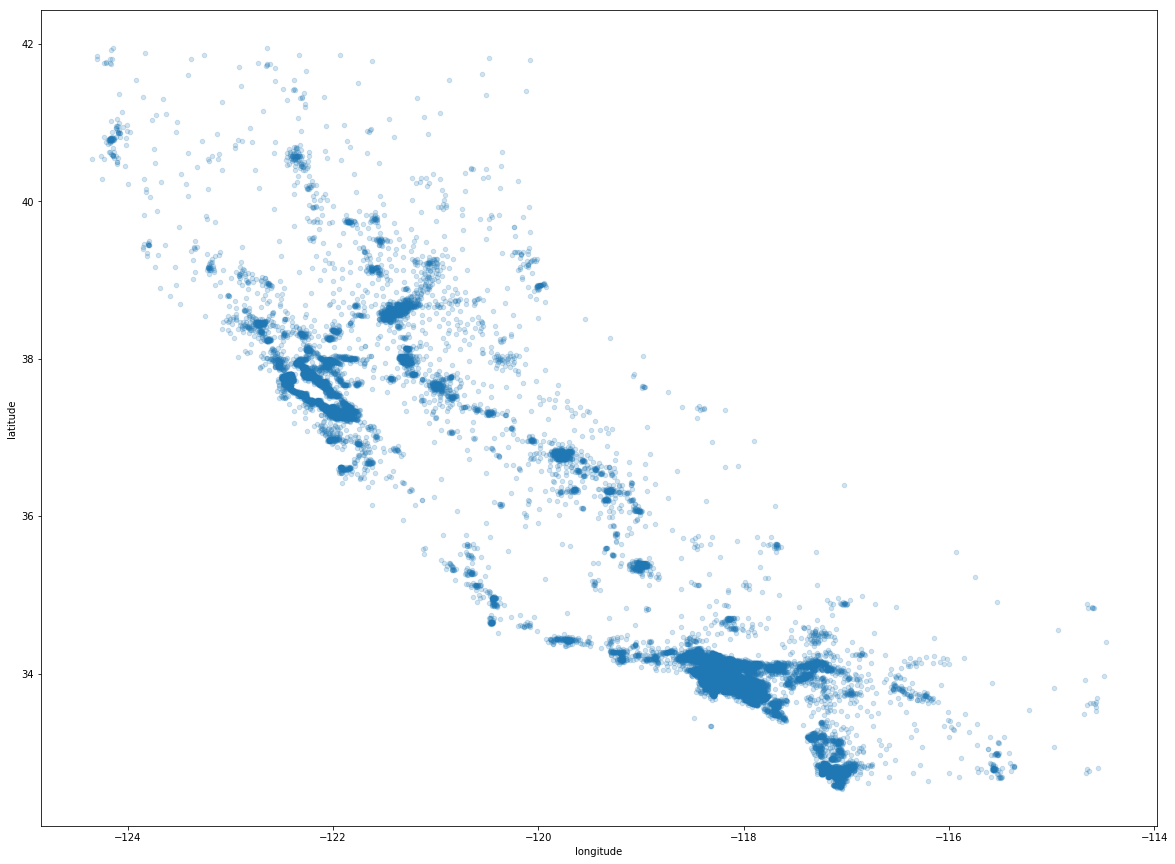

In [79]:
train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, figsize=(20,15))

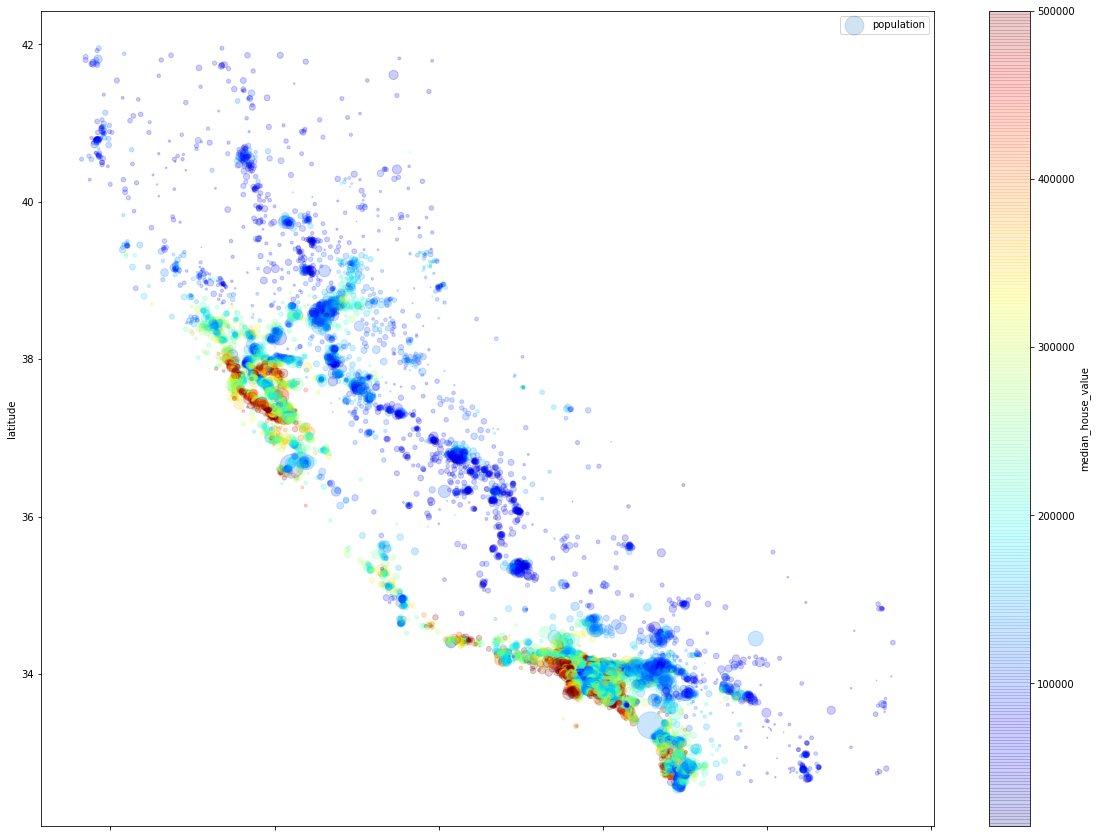

In [87]:
train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, 
           s = train.population/50, label="population", 
           c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar=True,
           figsize=(20,15));
plt.legend()